In [8]:
import warnings;

from keras import Model

warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl
import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense,Dropout
from keras.layers import Flatten,Input,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D

In [10]:
path='./'
fw='weights.housenumbers.hdf5'
glob.glob(path+'*')

['.\\extra_images.csv',
 '.\\extra_images_2.csv',
 '.\\extra_labels.csv',
 '.\\extra_labels_2.csv',
 '.\\svhn-digit-recognition.ipynb',
 '.\\test_images.csv',
 '.\\test_images_2.csv',
 '.\\test_labels.csv',
 '.\\test_labels_2.csv',
 '.\\train_images.csv',
 '.\\train_images_2.csv',
 '.\\train_labels.csv',
 '.\\train_labels_2.csv',
 '.\\weights.housenumbers.hdf5']

##  Data Loading & Preprocessing

Label:  [10 10 10  4  6]
[[0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]


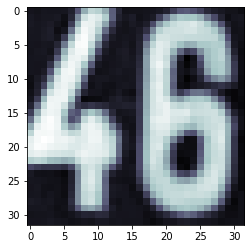

In [12]:
train_images=pd.read_csv(path+'train_images.csv')
train_labels=pd.read_csv(path+'train_labels.csv')
test_images=pd.read_csv(path+'test_images.csv')
test_labels=pd.read_csv(path+'test_labels.csv')
extra_images=pd.read_csv(path+'extra_images.csv')
extra_labels=pd.read_csv(path+'extra_labels.csv')
train_images=train_images.iloc[:,1:]\
.values.astype('float32').reshape(-1,32,32,1)
train_labels=train_labels.iloc[:,1:]\
.values.astype('int16')
test_images=test_images.iloc[:,1:]\
.values.astype('float32').reshape(-1,32,32,1)
test_labels=test_labels.iloc[:,1:]\
.values.astype('int16')
extra_images=extra_images.iloc[:,1:]\
.values.astype('float32').reshape(-1,32,32,1)
extra_labels=extra_labels.iloc[:,1:]\
.values.astype('int16')
ctrain_labels=to_categorical(train_labels,num_classes=11)\
.astype('int16')
ctest_labels=to_categorical(test_labels,num_classes=11)\
.astype('int16')
cextra_labels=to_categorical(extra_labels,num_classes=11)\
.astype('int16')
n=np.random.randint(1,2000,1)[0]
print('Label: ',train_labels[n])
print(ctrain_labels[n])
pl.imshow(train_images[n].reshape(32,32),
          cmap=pl.cm.bone);

In [13]:
X=np.concatenate((train_images,
                        test_images),axis=0)
X=np.concatenate((X,extra_images),axis=0)
y=np.concatenate((ctrain_labels,
                  ctest_labels),axis=0)
y=np.concatenate((y,cextra_labels),axis=0)
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
x_train,x_valid,x_test,\
y_train,y_valid,y_test=tts(X,y)
y_train_list=[y_train[:,i] for i in range(5)]
y_test_list=[y_test[:,i] for i in range(5)]
y_valid_list=[y_valid[:,i] for i in range(5)]
for el in [x_train,x_valid,x_test,
           y_train,y_valid,y_test]:
    print(el.shape)

(25600, 32, 32, 1)
(3200, 32, 32, 1)
(3200, 32, 32, 1)
(25600, 5, 11)
(3200, 5, 11)
(3200, 5, 11)


## Build the Model

In [14]:
def cnn_model():    
    model_input=Input(shape=(32,32,1))
    x=BatchNormalization()(model_input)        
    x=Conv2D(32,(3,3),activation='relu',
             padding='same')(model_input)
    x=MaxPooling2D(pool_size=(2,2))(x)     
    x=Conv2D(32,(3,3),activation='relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)    
    x=Conv2D(64,(3,3),activation='relu')(x)       
    x=Conv2D(64,(3,3),activation='relu')(x)    
    x=Dropout(.25)(x)    
    x=Conv2D(196,(3,3),activation='relu')(x)    
    x=Dropout(.25)(x)              
    x=Flatten()(x)    
    x=Dense(512,activation='relu')(x)    
    x=Dropout(.5)(x)    
    y=[Dense(11,activation='softmax')(x)
       for i in range(5)]    
    model=Model(inputs=model_input,outputs=y)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

cnn_model=cnn_model()

In [15]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,
                             save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=16,verbose=2)
history=cnn_model.fit(x_train,y_train_list,
                      validation_data=(x_valid,y_valid_list), 
                      epochs=20,batch_size=128,verbose=2,
                      callbacks=[checkpointer,lr_reduction,estopping])

Epoch 1/20

Epoch 00001: val_loss improved from inf to 5.76710, saving model to weights.housenumbers.hdf5
200/200 - 21s - loss: 6.4707 - dense_1_loss: 0.0882 - dense_2_loss: 0.3228 - dense_3_loss: 1.3770 - dense_4_loss: 2.3315 - dense_5_loss: 2.3512 - dense_1_accuracy: 0.9945 - dense_2_accuracy: 0.9446 - dense_3_accuracy: 0.5974 - dense_4_accuracy: 0.1531 - dense_5_accuracy: 0.1119 - val_loss: 5.7671 - val_dense_1_loss: 0.0077 - val_dense_2_loss: 0.2323 - val_dense_3_loss: 1.1493 - val_dense_4_loss: 2.0894 - val_dense_5_loss: 2.2885 - val_dense_1_accuracy: 0.9997 - val_dense_2_accuracy: 0.9438 - val_dense_3_accuracy: 0.6194 - val_dense_4_accuracy: 0.2544 - val_dense_5_accuracy: 0.1294 - lr: 0.0010 - 21s/epoch - 106ms/step
Epoch 2/20

Epoch 00002: val_loss improved from 5.76710 to 5.44789, saving model to weights.housenumbers.hdf5
200/200 - 18s - loss: 5.6594 - dense_1_loss: 0.0056 - dense_2_loss: 0.2058 - dense_3_loss: 1.0940 - dense_4_loss: 2.0601 - dense_5_loss: 2.2940 - dense_1_accu

In [17]:
cnn_model.load_weights(fw)
cnn_scores=cnn_model.evaluate(x_test,y_test_list,verbose=0)
print("CNN. Scores: \n" ,(cnn_scores))
avg_accuracy=sum([cnn_scores[i] for i in range(6,11)])/5
print("CNN Model. Average Accuracy: %.2f%%"%(avg_accuracy*100))

CNN. Scores: 
 [1.3000767230987549, 0.001742635853588581, 0.052605386823415756, 0.3508732318878174, 0.4095848798751831, 0.4852706491947174, 0.9996874928474426, 0.987500011920929, 0.8868749737739563, 0.8815624713897705, 0.8518750071525574]
CNN Model. Average Accuracy: 92.15%


Label:  [10 10 10  5  4]
[[0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0]]


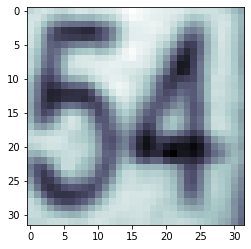

In [19]:
n=np.random.randint(1,2000,1)[0]
print('Label: ',train_labels[n])
print(ctrain_labels[n])
pl.imshow(train_images[n].reshape(32,32),
          cmap=pl.cm.bone);

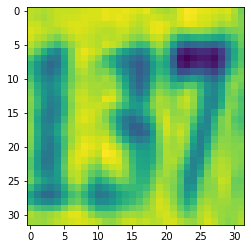

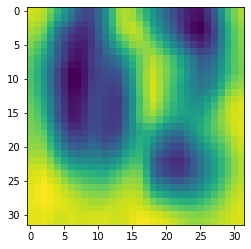

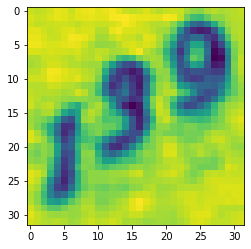

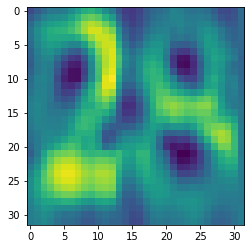

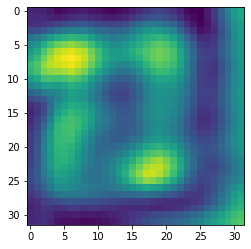

In [23]:
from random import sample

samples_to_predict = []
images = sample(list(test_images), 5)

# Generate plots for samples
for sample in images:
  # Generate a plot
  reshaped_image = sample.reshape((32, 32))
  pl.imshow(reshaped_image)
  pl.show()
  # Add sample to array for prediction
  samples_to_predict.append(sample)

In [24]:
samples_to_predict = np.array(samples_to_predict)
print(samples_to_predict.shape)

predictions = cnn_model.predict(samples_to_predict)


(5, 32, 32, 1)


In [25]:
classes = np.argmax(predictions, axis=2)
classes

array([[10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10],
       [ 1, 10,  1, 10, 10],
       [ 3,  9,  3,  2,  7],
       [ 7,  2,  9,  8,  2]], dtype=int64)

In [26]:
predictions

[array([[1.8493177e-11, 1.2376001e-09, 1.1345305e-11, 3.1212561e-14,
         9.7605699e-15, 1.2675112e-14, 3.9022737e-14, 1.9382760e-14,
         3.2672761e-14, 4.5162472e-14, 1.0000000e+00],
        [9.8786646e-10, 3.8494128e-09, 5.0797908e-09, 3.4910641e-10,
         1.8604703e-10, 1.1608046e-10, 1.3067068e-10, 1.0875794e-10,
         3.4323611e-10, 1.7987707e-10, 1.0000000e+00],
        [2.9811642e-06, 1.0415438e-04, 1.7123379e-05, 3.6628774e-07,
         2.8021196e-07, 2.0603409e-07, 4.3857253e-07, 3.0455035e-07,
         2.7725949e-07, 2.9538614e-07, 9.9987352e-01],
        [1.6152510e-11, 9.4012166e-11, 2.3462451e-10, 5.8335611e-12,
         2.3384335e-12, 6.7209183e-13, 1.3835033e-12, 1.1143084e-12,
         2.2080885e-12, 1.1967880e-12, 1.0000000e+00],
        [4.1104617e-08, 2.8315927e-08, 1.0296004e-07, 4.6349960e-08,
         2.7401745e-08, 1.9187384e-08, 4.2921929e-08, 2.2242221e-08,
         4.1145874e-08, 2.8859654e-08, 9.9999952e-01]], dtype=float32),
 array([[1.0050253